In [2]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal

import numpy as np
import pandas as pd

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from mvee import EllipsoidTool as ET

In [3]:
wsrc = '../clean2/'
dst =  '../rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

rotX, rotY, rotZ = False, False, False
flipx = np.eye(3)

walnut_batch = sorted(glob.glob( wsrc + '*/' ))
bidx = 0
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))

bname = walnut_batch[bidx].split('/')[-2]

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

../rotated/2014SBa_R1_T25/


In [4]:
widx = 0
print(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

img = tf.imread(walnut_files[widx])
mxval = 2**(8*img.itemsize)

nutvol = np.sum(img > 0) * (resol ** 3)

../clean2/2014SBa_R1_T25/2014SBa_R1_T25_001.tif
2014SBa_R1_T25_001


In [5]:
NNN = 25
bottom = img[:NNN,:, :]
top = img[-NNN:, :, :]

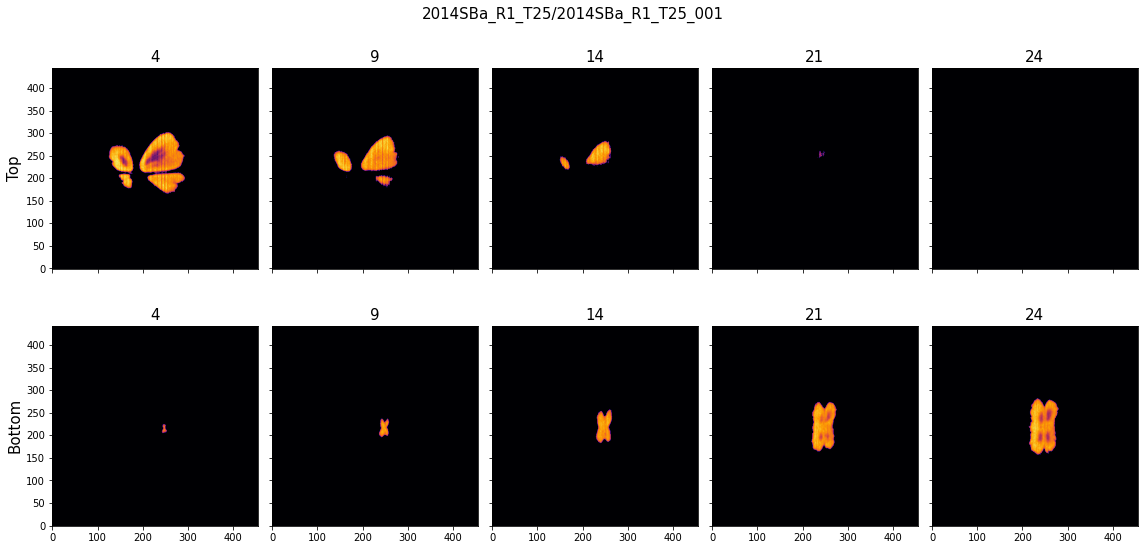

In [6]:
thrs = [4,9,14,21,24]
ssp = [np.s_[t,:,:] for t in thrs]
ssn = [np.s_[-t,:,:] for t in thrs]

fig, ax = plt.subplots(2,len(thrs),figsize=(16,8), sharex=True, sharey=True)

for i in range(len(thrs)):
    ax[0,i].imshow(top[ssp[i]], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[0,i].set_title(thrs[i], fontsize=fs)
for i in range(len(thrs)):
    ax[1,i].imshow(bottom[ssp[i]], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[1,i].set_title(thrs[i], fontsize=fs)
    
ax[0,0].set_ylabel('Top', fontsize=fs)
ax[1,0].set_ylabel('Bottom', fontsize=fs)
    
fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

Top:	 135148
Bot:	 49731 

Tip is at the Bottom
Tipvox:	 [  2.         214.08333333 248.22222222]


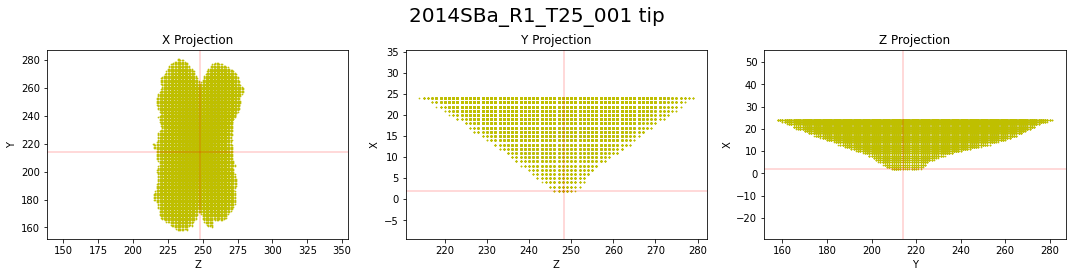

In [7]:
reload(wnut)
topsum = np.sum(top > 0)
botsum = np.sum(bottom > 0)

print('Top:\t', topsum)
print('Bot:\t', botsum,'\n')

if botsum > topsum:
    coords = np.asarray(np.nonzero(top))
    tipvox = wnut.find_tip_max(coords, 2,1,0)
    tipvox0 = tipvox.copy()
    tipvox[0] += (img.shape[0] - NNN)
    
    print('Base is at the Bottom\nTipvox:\t', tipvox)
    
else:
    coords = np.asarray(np.nonzero(bottom))
    tipvox = wnut.find_tip_min(coords, 2,1,0)
    tipvox0 = tipvox.copy()
    
    print('Tip is at the Bottom\nTipvox:\t', tipvox)
    
fig, ax = wnut.plot_3Dprojections(coords, fname + ' tip', alpha=1, writefig=False, dst=wdst, origin=tipvox0);

### Surface area

In [8]:
bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
nutvoxarea = np.sum(border)

print('Border made of\t', nutvoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(nutarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(nutarea),2), 'mm')

datapoints = np.asarray(np.nonzero(border))
wmean = np.mean(datapoints, axis = 1)

datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

tipvox = tipvox - wmean
tipvox *= resol

if tipvox[0] < 0:
    rotX = True
    print('rot')
    datapoints[0] *= -1.
    tipvox[0] *= -1.
    flipx[0,0] *= -1

Border made of	 621779 pixels

Nut surface area:	 6720.75 mm^2
Approx by a square of size:	 81.98 mm
rot


*:	 [19.37647988 -3.76293056 -2.2432702 ]


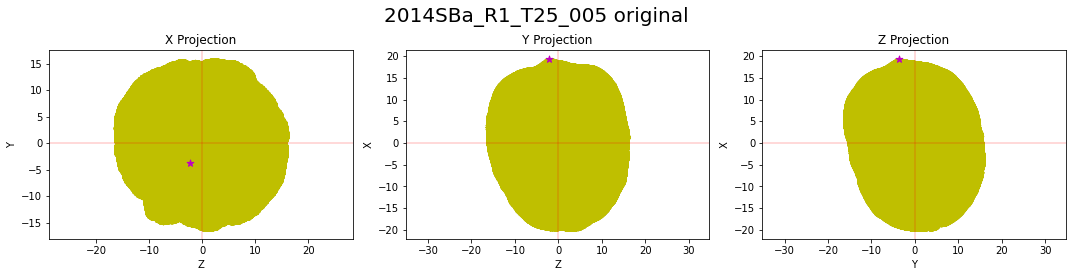

In [65]:
fig,ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=1, writefig=False, dst=wdst);

ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='m')
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='m')
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='m');

print('*:\t', tipvox)

### Alignment

[-4.61836615  1.80323424]


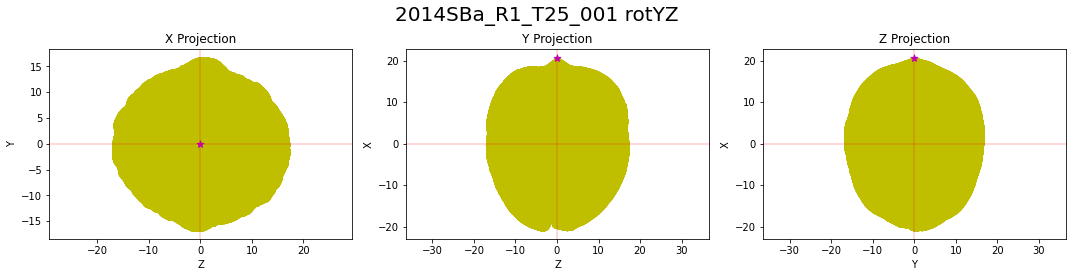

In [21]:
thetay = np.sign(tipvox[1]) * np.arccos(tipvox[0]/np.sqrt(tipvox[0]**2 + tipvox[2]**2))
thetaz = np.sign(tipvox[2]) * np.arccos(tipvox[0]/np.sqrt(tipvox[0]**2 + tipvox[1]**2))

print(np.rad2deg([thetay, thetaz]))

roty = np.array([[np.cos(thetay), 0,  np.sin(thetay)],
                 [0, 1, 0],
                 [-np.sin(thetay), 0, np.cos(thetay)]])

rotz = np.array([[np.cos(thetaz), -np.sin(thetaz), 0],
                 [np.sin(thetaz),  np.cos(thetaz), 0],
                 [0, 0, 1]])

rots = [rotz.T @ roty, rotz @ roty.T, rotz.T @ roty, rotz @ roty]
foo = np.zeros(len(rots))

for i in range(len(rots)):
    bar = rots[i] @ tipvox
    foo[i] = np.sum(bar[1:] ** 2)
    
rotyz = rots[np.argmin(foo)]

rcoords = rotyz @ datapoints
rtipvox = rotyz @ tipvox

fig, ax = wnut.plot_3Dprojections(rcoords, fname + ' rotYZ', alpha=1, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='m')
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='m')
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='m');

(2, 33025) 
---
PARAMS
---
axes	:
[16.46547254 15.00945453]
origin	:
[-0.12376719  0.13462614]
theta	:
-0.6578837744117445
rot	:
[[ 0.79128796  0.61144368]
 [-0.61144368  0.79128796]]
theta	 -37.69 deg


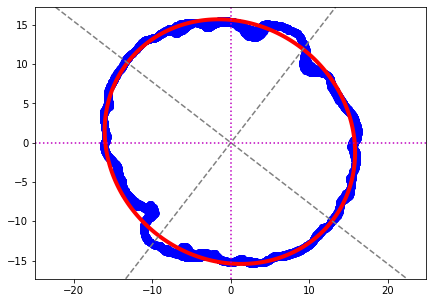

In [67]:
thr = 1
acoords = np.abs(rcoords)
tcoords = np.flip(rcoords[1:, (acoords[0] < thr)])
print(tcoords.shape,'\n---\nPARAMS\n---')

V = wnut.ell_algebraic_fit_2d(*tcoords)
pdict = wnut.get_ell2d_params_from_vector(V)
for key in pdict:
    print(key, '\t:\n', pdict[key], sep='')
print('theta\t',np.round(np.rad2deg(pdict['theta']),2),'deg')

# Plot the noisy data
plt.figure(figsize=(7,5))
plt.scatter(*tcoords, label='Data Points', c='blue')

# Plot the least squares ellipse
x_coord = np.linspace(np.min(tcoords)-1, np.max(tcoords)+1, 300)
y_coord = x_coord
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = V[0] * X_coord ** 2 + V[1] * X_coord * Y_coord + V[2] * Y_coord**2 + V[3] * X_coord + V[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=4);
plt.axis('equal');

plt.axline(xy1=(0,0), slope = np.tan(pdict['theta']), c='gray', ls='--')
plt.axline(xy1=(0,0), slope = -1/np.tan(pdict['theta']), c='gray', ls='--');

plt.axvline(0, c='m', ls=':')
plt.axhline(0, c='m', ls=':');

In [68]:
Q = pdict['rot'].T @ (tcoords - pdict['origin'].reshape(-1,1))
distances = np.zeros((Q.shape[1], 4))

for i in range(Q.shape[1]):
    distances[i] = wnut.d_ell_point(Q[0,i], Q[1,i], pdict)

P = pdict['rot'] @ (distances[:, 2:].T + pdict['origin'].reshape(-1,1))

In [69]:
phi = np.arccos(distances[:,2]/pdict['axes'][0])
phi[distances[:,3] < 0] = 2*np.pi - phi[distances[:,3] < 0]

stack = wnut.even_space_ell0(721, *pdict['axes'])
idxs = np.digitize(phi, bins=stack[0])
print(np.min(idxs), np.max(idxs))

sumdist = np.zeros(len(stack[0])-1)
for i in range(len(sumdist)):
    sumdist[i] = np.mean(distances[idxs == i+1, 0]*distances[idxs == i+1, 1])
sumdist[sumdist < 0] = 0

if np.argmax(sumdist) < len(sumdist)//2:
    rotZ = True
    print('rot')
    
cval = np.max(np.abs(tcoords))/np.max(sumdist)

1 720


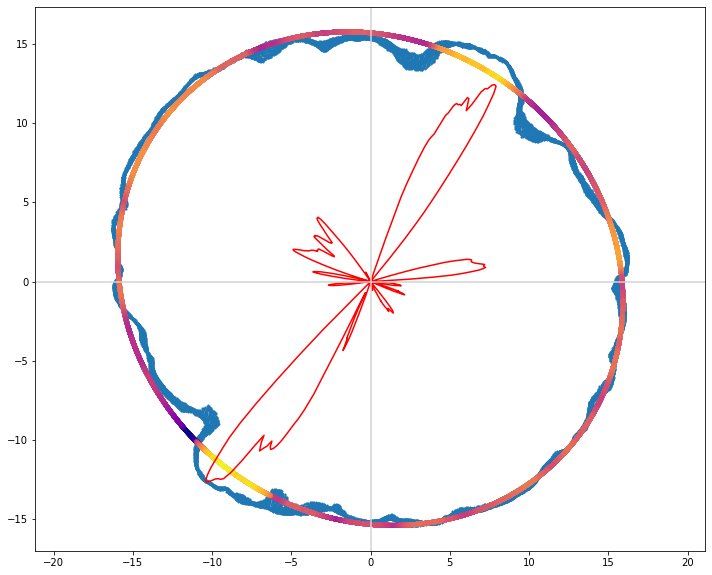

In [70]:
# Plot the noisy data
plt.figure(figsize=(12,10))
plt.scatter(*tcoords, s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
#plt.scatter(*Q, c=distances[:,0]*distances[:,1], cmap='plasma')

#plt.scatter(*ell0, c='gray', marker='o', s=15)
plt.scatter(*P, s=15, c=distances[:,0]*distances[:,1], cmap='plasma')
#plt.scatter(distances[:,2], distances[:,3], c=distances[:,0]*distances[:,1], cmap='plasma')

#plt.scatter(2*pdict['axes'][0]*np.cos(phi),2*pdict['axes'][1]*np.sin(phi), c=distances[:,0]*distances[:,1], cmap='plasma')

#plt.scatter(*stack[1:]*1.5, marker='^', c='blue', s=15)

plt.plot(cval*sumdist*np.cos(stack[0][:-1] + pdict['theta']), cval*sumdist*np.sin(stack[0][:-1] + pdict['theta']), c='r')

plt.axvline(0, c= 'lightgray')
plt.axhline(0, c= 'lightgray')
plt.axis('equal');

filename = 'seal_finding.jpg'
#plt.savefig(filename, dpi=150, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

0.9475704491766432 54.29178752913733


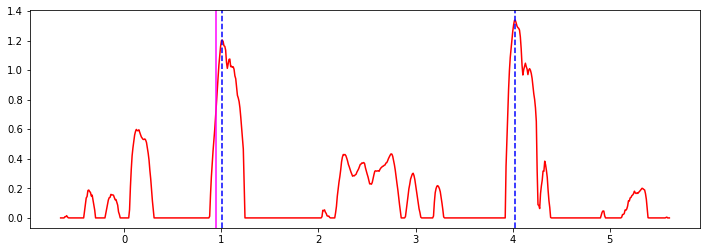

In [71]:
sumdist3 = np.hstack((sumdist,sumdist,sumdist))
rawpeakidx, _ = signal.find_peaks(sumdist3, distance=len(sumdist)//4)
foo = rawpeakidx[(rawpeakidx > len(sumdist)) & (rawpeakidx < 2*len(sumdist))]
srtpeakidx = foo[np.argsort(sumdist3[foo])[-2:][::-1]] - len(sumdist)

thetax = np.mean(stack[0][srtpeakidx]) - np.pi*.5 + pdict['theta']

if rotZ:
    thetax += np.pi
    print('rot')

print(thetax, np.rad2deg(thetax))

plt.figure(figsize=(12,4))
plt.plot(stack[0][:-1] + pdict['theta'], sumdist, c='r');
for x in stack[0][srtpeakidx] + pdict['theta']:
    plt.axvline(x, c='blue', ls='--');
plt.axvline(thetax, c='magenta');

In [48]:
rotx = np.array([[1,0,0], 
                 [0, np.cos(thetax), -np.sin(thetax)],
                 [0, np.sin(thetax),  np.cos(thetax)]])

rotxyz = rotx @ rotyz

bulgerot2d = rotx[1:,1:]

../rotated/2014SBa_R1_T25/2014SBa_R1_T25_007_seal.jpg


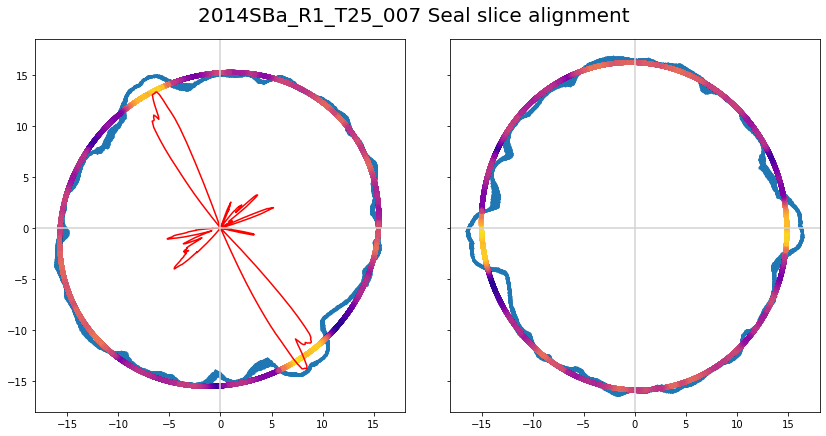

In [49]:
fig, ax = plt.subplots(1,2,figsize=(12,6), sharex=True, sharey=True)

ax[0].scatter(*tcoords, s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[0].scatter(*P, s=15, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[0].plot(cval*sumdist*np.cos(stack[0][:-1] + pdict['theta']), cval*sumdist*np.sin(stack[0][:-1] + pdict['theta']), c='r')

ax[1].scatter(*(bulgerot2d.T @ tcoords), s=1)#, c=distances[:,0]*distances[:,1], cmap='plasma')
ax[1].scatter(*(bulgerot2d.T @ P), s=15, c=distances[:,0]*distances[:,1], cmap='plasma')

for i in range(len(ax)):
    ax[i].axvline(0, c= 'lightgray')
    ax[i].axhline(0, c= 'lightgray')
    ax[i].set_aspect('equal');

fig.suptitle(fname + ' Seal slice alignment', fontsize=20)
fig.tight_layout()

filename = wdst + fname + '_seal.jpg'
print(filename)
#plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

Tip coords:	 [19.16 -0.    0.  ]

[19.25910786 16.65981453 16.48829104]

[38.51821571 33.31962906 32.97658209]


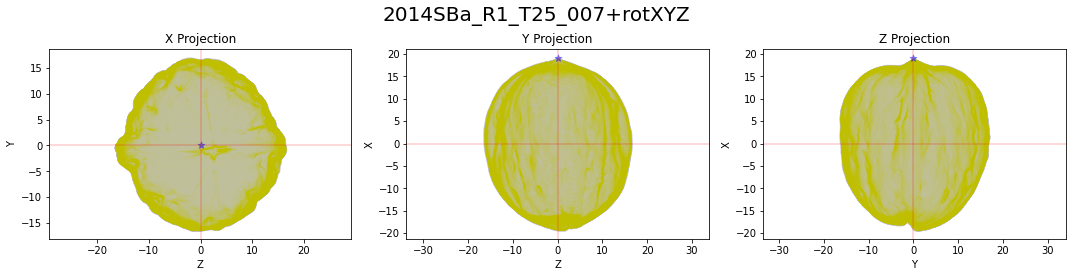

In [50]:
rcoords = rotxyz @ datapoints
rtipvox = rotxyz @ tipvox
print('Tip coords:\t', np.round(rtipvox, 2))

minis = np.min(rcoords, axis=1)
maxes = np.max(rcoords, axis=1)

print('\n', (maxes - minis)/2, '\n\n', maxes - minis, sep='')

fig, ax = wnut.plot_3Dprojections(rcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

In [51]:
hull = spatial.ConvexHull(rcoords.T)

In [52]:
align = np.vstack((wmean, rotx, roty, rotz, flipx @ rotxyz,
                   np.array([rotX,rotY,rotZ]).astype(int),
                   tipvox, rtipvox,
                   minis, maxes, maxes - minis,
                   [nutvol, nutarea, nutvoxarea],
                   [hull.area, hull.volume, 0]))
filename = wdst + fname + '_rotation.csv'
print(filename)
np.savetxt(filename, align, delimiter=',')
print(align.shape)

../rotated/2014SBa_R1_T25/2014SBa_R1_T25_007_rotation.csv
(21, 3)
